In [1]:
import os

import pandas as pd
import numpy as np

In [2]:
from pathlib import Path 

FILE_PATH = Path('/Users/farizrzayev/Desktop/projects/capslock/_input_data')


#### Read Dataframes

In [3]:
internal_db = pd.read_csv('_input_data/CapsLock_internal_db_Test.csv', encoding='utf-16', sep='\t')
leads = pd.read_excel(FILE_PATH / 'CapsLock_Leads_Test.xlsx')
tasks = pd.read_excel(FILE_PATH/ 'CapsLock_Tasks_Test.xlsx')
sets = pd.read_excel(FILE_PATH/'CapsLock_Sets_Test.xlsx')
issued = pd.read_excel(FILE_PATH/ 'CapsLock_Issued_Test.xlsx')

In [4]:
print("# of internal db records", len(internal_db))
print("# of issues  records", len(issued))
print("# of leads records", len(leads))
print("# of contacts records", len(sets))
print("# of tasks records", len(tasks))

# Check for null values in each DataFrame

print("\nNull value counts:")
print("Internal DB nulls:\n", internal_db.isnull().sum())
print("\nIssues nulls:\n", issued.isnull().sum())
print("\nLeads nulls:\n", leads.isnull().sum())
print("\nAppointments nulls:\n", sets.isnull().sum())
print("\nTasks nulls:\n", tasks.isnull().sum())

# of internal db records 1170
# of issues  records 128
# of leads records 1054
# of contacts records 237
# of tasks records 5592

Null value counts:
Internal DB nulls:
 Lavin Media Id     0
Created time       0
Source             0
Landing page      16
Thank You page    12
dtype: int64

Issues nulls:
 Net Sales              0
Gross Sales            0
Cancelled Sales        0
Date                   0
Created Date           0
Created Time           0
Status                 0
Contact: Contact ID    0
dtype: int64

Leads nulls:
 Created Time                      20
# Call Center Tasks Completed    177
Lavin Media ID                    29
Contact ID                       756
Region                             0
dtype: int64

Appointments nulls:
 Date                   0
Created Date           0
Created Time           0
Status                 0
Contact: Contact ID    0
dtype: int64

Tasks nulls:
 Created Time                      327
Call Result                       375
Lavin Media ID      

#### Data preprocessing / Augmentation

In [5]:
# Data preprocessing
internal_db['Lavin Media Id'] = internal_db['Lavin Media Id'].astype(int)
internal_db.rename(columns={
    'Lavin Media Id': 'Lavin Media ID',
    'Created time': 'Lead created time',
    'Thank You page': 'Thank you page'
}, inplace=True)
internal_db['Lead created time'] = pd.to_datetime(internal_db['Lead created time'], format='%m/%d/%y %H:%M')


leads['Lavin Media ID'] = leads['Lavin Media ID'].fillna(-1)
leads['Lavin Media ID'] = leads['Lavin Media ID'].astype(int)
leads.rename(columns={
    'Created Time': "Lead created in client's system",
}, inplace=True)

tasks = tasks.dropna(subset=['Lavin Media ID'])
tasks['Lavin Media ID'] = tasks['Lavin Media ID'].astype(int)
tasks = tasks.sort_values(['Lavin Media ID', 'Created Time'])

sets.rename(columns={
    'Date': 'Appointment Date',
    'Contact: Contact ID': 'Contact ID',
    'Status': 'Appointment Result',
}, inplace=True)

sets['Appointment Date'] = pd.to_datetime(sets['Appointment Date'])
# Created Date and Created Time into Appointment Set Date
sets['Appointment Set Date'] = pd.to_datetime(sets['Created Date'].astype(str) + ' ' + sets['Created Time'].astype(str))

# Dropping the original Created Date and Created Time columns since we've combined them
sets.drop(columns=['Created Date', 'Created Time'], inplace=True)
sets = sets.sort_values(['Contact ID', 'Appointment Date'])
sets = sets.drop_duplicates(subset=['Contact ID'], keep='last')

issued.rename(columns={
      'Contact: Contact ID': 'Contact ID',
      'Gross Sales': 'Gross Sale',
      'Net Sales': 'Net Sale',
      'Cancelled Sales': 'Cancel Sale'
  }, inplace=True)
issued = issued.sort_values(['Contact ID', 'Date'])
issued = issued.drop_duplicates(subset=['Contact ID'], keep='last')
issued = issued[['Contact ID', 'Gross Sale', 'Net Sale', 'Cancel Sale']]

Non-matching Leads that does exist in Internal Database, but not in Leads (not included to CRM)

In [6]:
# Number of non-matching records: 145 -> Non-matching Leads that does exist in Internal Database, but not in Leads (not included to CRM)

s1 = set(internal_db['Lavin Media ID'].unique())
s2 = set(leads['Lavin Media ID'].unique())

non_matching_ids = s1 - s2
non_matching_records = internal_db[internal_db['Lavin Media ID'].isin(non_matching_ids)]
print(f"Number of non-matching records: {len(non_matching_records)}")
# non_matching_records.to_csv('non_matching_records.csv', index=False)
non_matching_records

Number of non-matching records: 145


,Lavin Media ID,Lead created time,Source,Landing page,Thank you page
0,9,2020-12-07 15:07:00,Source5,lp-v1,ty-v1
2,14,2020-12-08 09:43:00,Source5,NaN,ty-v1
16,119,2020-12-08 20:33:00,Source5,NaN,NaN
32,202,2020-12-09 13:35:00,Source3,NaN,NaN
34,207,2020-12-09 14:15:00,Source3,lp-v4,ty-v1
...,...,...,...,...,...
1165,5234,2020-12-30 11:50:00,Source3,lp-v8,ty-v2
1166,5236,2020-12-30 11:52:00,Source3,lp-v8,ty-v2
1167,5237,2020-12-30 11:52:00,Source3,lp-v16,ty-v2
1168,5249,2020-12-30 11:56:00,Source2,lp-v12,ty-v2


In [7]:
merged_leads_data = pd.merge(internal_db, leads, on='Lavin Media ID', how='inner')

In [8]:
 # first task for each Lavin Media ID
first_tasks = tasks.groupby('Lavin Media ID').first().reset_index()
first_tasks = first_tasks[['Lavin Media ID', 'Created Time', 'Call Result']].rename(columns={
  'Created Time': 'First task completed date',
  'Call Result': 'First task Result'
})

# last task for each Lavin Media ID
last_tasks = tasks.groupby('Lavin Media ID').last().reset_index()
last_tasks = last_tasks[['Lavin Media ID', 'Created Time', 'Call Result']].rename(columns={
  'Created Time': 'Last task Completed date',
  'Call Result': 'Last task Result'
})

In [9]:
# Merge with merged_leads_data
merged_leads_data = merged_leads_data.merge(first_tasks, on='Lavin Media ID', how='left')
merged_leads_data = merged_leads_data.merge(last_tasks, on='Lavin Media ID', how='left')

In [10]:
merged_leads_data = merged_leads_data.merge(sets, on='Contact ID', how='left')
merged_leads_data = merged_leads_data.merge(issued, on='Contact ID', how='left')

### Final Master Dataset

In [11]:
merged_leads_data

,Lavin Media ID,Lead created time,Source,Landing page,Thank you page,Lead created in client's system,# Call Center Tasks Completed,Contact ID,Region,First task completed date,First task Result,Last task Completed date,Last task Result,Appointment Date,Appointment Result,Appointment Set Date,Gross Sale,Net Sale,Cancel Sale
0,11,2020-12-08 05:14:00,Source5,lp-v1,ty-v2,2020-12-08 05:16:00,10.0,NaN,Lexington,2020-12-08 11:02:00,Not Answered,2020-12-18 18:42:00,Not Answered,NaT,NaN,NaT,NaN,NaN,NaN
1,19,2020-12-08 12:01:00,Source3,lp-v1,ty-v2,2020-12-09 21:31:00,3.0,0031G000016rHzn,Pittsburgh,NaT,None,NaT,None,2020-12-16,Demo/Maybe,2020-12-11 17:34:00,0.0,0.0,0.0
2,49,2020-12-08 16:46:00,Source3,lp-v1,ty-v1,2020-12-09 21:31:00,4.0,NaN,Pittsburgh,2020-12-10 08:57:00,Out of Scope,2020-12-10 13:17:00,Not Answered,NaT,NaN,NaT,NaN,NaN,NaN
3,52,2020-12-08 16:58:00,Source3,lp-v1,ty-v2,2020-12-09 21:31:00,21.0,NaN,Lexington,2020-12-10 10:04:00,Left Voicemail,2020-12-28 14:13:00,VM10,NaT,NaN,NaT,NaN,NaN,NaN
4,53,2020-12-08 17:00:00,Source5,lp-v1,ty-v1,2020-12-09 21:31:00,NaN,0031G000016qulc,Lexington,NaT,None,NaT,None,2020-12-11,Sold,2020-12-08 22:08:00,9671.0,9671.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,5100,2020-12-30 10:39:00,Source3,lp-v8,ty-v2,2020-12-30 10:41:00,1.0,NaN,Ocala,2020-12-30 10:43:00,No Answer,2020-12-30 10:43:00,No Answer,NaT,NaN,NaT,NaN,NaN,NaN
1021,5105,2020-12-30 10:42:00,Source3,lp-v8,ty-v2,2020-12-30 10:54:00,1.0,NaN,Charlotte,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaN,NaN
1022,5114,2020-12-30 10:48:00,Source3,lp-v17,ty-v2,2020-12-30 10:49:00,1.0,NaN,Greenville - New Bern,NaT,None,NaT,None,NaT,NaN,NaT,NaN,NaN,NaN
1023,5120,2020-12-30 10:51:00,Source3,lp-v8,ty-v2,2020-12-30 10:53:00,1.0,NaN,Columbia,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaN,NaN


In [12]:
def clean_leads_data(df):
    df = df.copy()
    
    df['Contact ID'] = df['Contact ID'].fillna('UNK')
    df['# Call Center Tasks Completed'] = df['# Call Center Tasks Completed'].fillna('0').astype(int)
    df['Net Sale'] = df['Net Sale'].fillna(0).astype(float)
    df['Gross Sale'] = df['Gross Sale'].fillna(0)
    df['Cancel Sale'] = df['Cancel Sale'].astype(float)

    # Case 1 & 2: Completed appointment but Cancel Sale is NaN , so can be set to 0
    df['Cancel Sale'] = np.where((df['Appointment Result'].notna()) & (df['Cancel Sale'].isna()) & (~df['Appointment Result'].isin(["Customer Canceled", "Company Canceled"])),
        0,
        df['Cancel Sale']
    )
    
    
    # Case 3: Appointment canceled and Cancel Sale is NaN , so maybe full refund for the future
    df['Cancel Sale'] = np.where((df['Appointment Result'].isin(["Customer Canceled", "Company Canceled"])) & (df['Cancel Sale'].isna()),df['Gross Sale'], df['Cancel Sale']
    )

    # Case 4: Na replacemenet with Naive way since if we filter it, we see that they are same NaNs for Sales cols;
    df['Cancel Sale'] = df['Cancel Sale'].fillna(0)
    df['Cancel Sale'] = df['Cancel Sale'].astype(int)
    
    df['Last task Result'] = df['Last task Result'].fillna("Not Attempted")
    df['First task Result'] = df['First task Result'].fillna("Not Attempted")
    
    df['Appointment Result'] = np.where( df['Appointment Date'].isna(), "No Appointment",  df['Appointment Result']
    )

    # mapping to the same label
    mapping = {'No Answer': 'Not Answered'}
    df['First task Result'] = df['First task Result'].map(mapping).fillna(df['First task Result'])
    df['Last task Result'] = df['Last task Result'].map(mapping).fillna(df['Last task Result'])

    return df


clean_leads_data(merged_leads_data).to_excel('leads_master_dataset.xlsx')



In [32]:
df = clean_leads_data(merged_leads_data)

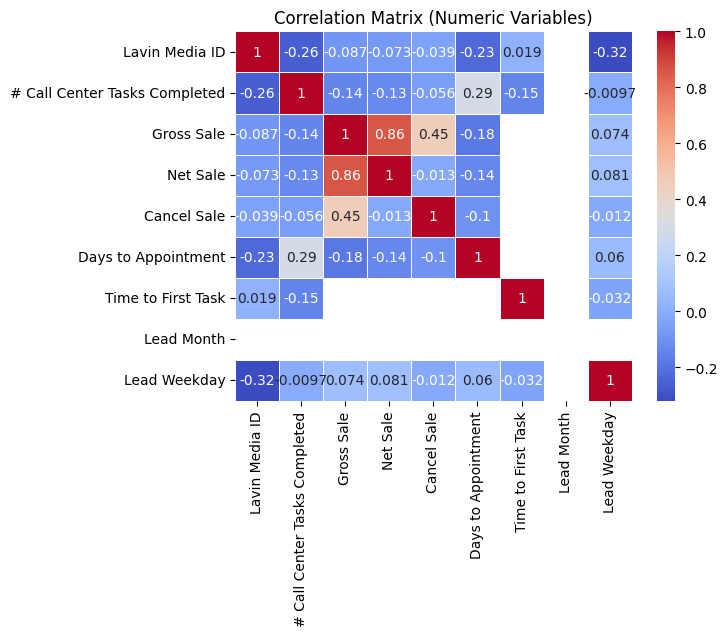

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_cols = df.select_dtypes(include='number')
correlation_matrix = numeric_cols.corr()

# Heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix (Numeric Variables)")
plt.show()


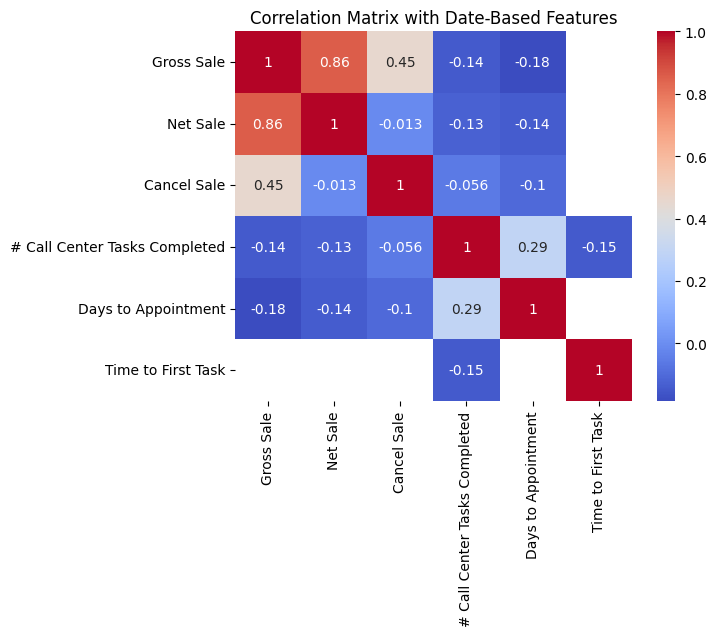

In [36]:

df['Lead created time'] = pd.to_datetime(df['Lead created time'])
df['Appointment Date'] = pd.to_datetime(df['Appointment Date'])
df['First task completed date'] = pd.to_datetime(df['First task completed date'])

# Days to Appointment
df['Days to Appointment'] = (df['Appointment Date'] - df['Lead created time']).dt.days

# Time to First Task
df['Time to First Task'] = (df['First task completed date'] - df['Lead created time']).dt.days

numeric_cols = df[['Gross Sale', 'Net Sale', 'Cancel Sale', '# Call Center Tasks Completed',
                   'Days to Appointment', 'Time to First Task']]

sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix with Date-Based Features")
plt.show()

In [160]:
# len(internal_db)

In [161]:
# len(merged_leads_data)

In [163]:
# duplicate contact IDs, which only one of them made net sales (Sold) = 0031G000018qEGO, rest is one No Demo & one Demo/Maybe 
# len(issues[issues['Contact: Contact ID'].duplicated()])  # 8 duplicated records
# duplicate_contact_id =  [
#         '0031G000018qZLC',                  
#         '0031G000018qFhb',
#         '0031G000016rAiq',
#         '0031G000018qEGO',
#         '0031G000018pb5k',
#         '0031G000016rAiq',
#         '0031G000016rJMd',
#         '0031G000018qcLe'
#  ]
# 
# issued[issued['Contact: Contact ID'].isin(duplicate_contact_id) ]
# 
# 
# # Has sales ?
# issued['is_sales'] = np.where(
#                         (issued['Net Sales'] == 0) 
#                                 & (issued['Gross Sale'] == 0) 
#                                 & (issued['Cancelled Sales'] == 0)
#                                 | ((issued['Status'] == "No Demo") | (issued['Status']) == "Demo/Maybe")
#                                 , 'No Sales','Has Sales')
# 
# 
# issued.groupby(['is_sales'])['Net Sales'].sum().reset_index()


In [156]:

# # UNK - Unknown IDs
# merged_leads_data['Contact ID'] = merged_leads_data['Contact ID'].fillna('UNK')
# merged_leads_data['# Call Center Tasks Completed'] = merged_leads_data['# Call Center Tasks Completed'].fillna('0')
# merged_leads_data['# Call Center Tasks Completed'] = merged_leads_data['# Call Center Tasks Completed'].astype(int)
# 
# 
# merged_leads_data['Net Sale'] = merged_leads_data['Net Sale'].fillna(0)
# merged_leads_data['Net Sale'] = merged_leads_data['Net Sale'].astype(float)
# 
# 
# merged_leads_data['Gross Sale'] = merged_leads_data['Gross Sale'].fillna(0)
# merged_leads_data['Cancel Sale'] = merged_leads_data['Cancel Sale'].astype(float)
# 
# 
# # Case 1 & 2: If Appointment was completed (Sold/No Sale), Cancel Sale = 0
# merged_leads_data['Cancel Sale'] = np.where(
#                     (merged_leads_data['Appointment Result'].notna()) & 
#                     (merged_leads_data['Cancel Sale'].isna()) & 
#                     (~merged_leads_data['Appointment Result'].isin(["Customer Canceled", "Company Canceled"])),
#                     0,
#                     merged_leads_data['Cancel Sale']
# )
# 
# # Case 3: If Appointment was canceled but Cancel Sale is NaN, assume full cancellation (Gross Sale)
# merged_leads_data['Cancel Sale'] = np.where(
#                     (merged_leads_data['Appointment Result'].isin(["Customer Canceled", "Company Canceled"])) & 
#                     (merged_leads_data['Cancel Sale'].isna()),
#                     merged_leads_data['Gross Sale'],  # Assuming full refund
#                     merged_leads_data['Cancel Sale']
# )
# 
# 
# 
# merged_leads_data['Last task Result'] = merged_leads_data['Last task Result'].fillna("Not Attempted")
# merged_leads_data['First task Result'] = merged_leads_data['First task Result'].fillna("Not Attempted")
# 
# 
# merged_leads_data['Appointment Result'] = np.where(merged_leads_data['Appointment Date'].isna(), "No Appointment",  merged_leads_data['Appointment Result']
# )
# 
# # mapping of No Answer to Not Answered as in the dataset;
# mapping = {
#     'No Answer': 'Not Answered'
# }
# 
# merged_leads_data['First task Result'] = merged_leads_data['First task Result'].map(mapping).fillna(merged_leads_data['First task Result'])
# 
# merged_leads_data['Last task Result'] = merged_leads_data['Last task Result'].map(mapping).fillna(merged_leads_data['Last task Result'])
# 
# merged_leads_data
# 
# 